In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import zscore

In [3]:
np.random.seed(42)

In [18]:
from scipy.stats import zscore
def load_and_prepare_data():
    df = pd.read_csv("/content/tips (data for regression problem).csv")
    df['tip_percentage'] = (df['tip'] / df['total_bill']) * 100
    df['per_person_bill'] = df['total_bill'] / df['size']
    df['per_person_tip'] = df['tip'] / df['size']

    le = LabelEncoder()
    categorical_columns = ['sex', 'smoker', 'day', 'time']
    for column in categorical_columns:
        df[f'{column}_encoded'] = le.fit_transform(df[column])

    # Outlier Removal
    df = df[(np.abs(zscore(df[['total_bill', 'tip']])) < 3).all(axis=1)]
    return df

In [5]:
def analyze_data_distribution(df):
    plt.figure(figsize=(15, 10))

    # Distribution of tip amounts
    plt.subplot(2, 2, 1)
    sns.histplot(df['tip'], bins=30)
    plt.title('Distribution of Tips')

    # Distribution of bill amounts
    plt.subplot(2, 2, 2)
    sns.histplot(df['total_bill'], bins=30)
    plt.title('Distribution of Total Bills')

    # Distribution of tip percentages
    plt.subplot(2, 2, 3)
    sns.histplot(df['tip_percentage'], bins=30)
    plt.title('Distribution of Tip Percentages')

    # Tips vs Total Bill
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=df, x='total_bill', y='tip')
    plt.title('Tips vs Total Bill')

    plt.tight_layout()
    plt.show()


In [6]:
def check_linearity(df):
    # Create pair plot for numerical variables
    numerical_cols = ['total_bill', 'tip', 'size', 'tip_percentage', 'per_person_bill', 'per_person_tip']
    sns.pairplot(df[numerical_cols])
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Rainbow test for linearity
    X = df[['total_bill', 'size']]
    y = df['tip']
    model = sm.OLS(y, sm.add_constant(X))
    results = model.fit()
    rainbow_statistic, rainbow_p_value = sm.stats.diagnostic.linear_rainbow(results)
    print(f"\nRainbow Test Results:")
    print(f"Statistic: {rainbow_statistic:.4f}")
    print(f"P-value: {rainbow_p_value:.4f}")

In [7]:
def analyze_categorical_relationships(df):
    plt.figure(figsize=(15, 10))

    # Tips by day
    plt.subplot(2, 2, 1)
    sns.boxplot(data=df, x='day', y='tip')
    plt.title('Tips by Day')

    # Tips by time
    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x='time', y='tip')
    plt.title('Tips by Time')

    # Tips by smoker status
    plt.subplot(2, 2, 3)
    sns.boxplot(data=df, x='smoker', y='tip')
    plt.title('Tips by Smoker Status')

    # Tips by gender
    plt.subplot(2, 2, 4)
    sns.boxplot(data=df, x='sex', y='tip')
    plt.title('Tips by Gender')

    plt.tight_layout()
    plt.show()

In [27]:
def prepare_modeling_data(df):
    feature_columns = ['total_bill', 'size', 'sex_encoded', 'smoker_encoded',
                       'day_encoded', 'time_encoded', 'per_person_bill']
    X = df[feature_columns]
    y = np.log(df['tip'])  # Log transformation for target

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, feature_columns

In [20]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_columns):
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0),
        'Decision Tree': DecisionTreeRegressor(max_depth=5),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5),
        'SVR': SVR(kernel='rbf'),
        'KNN': KNeighborsRegressor(n_neighbors=5)
    }

    results = {}
    for name, model in models.items():
        # Hyperparameter tuning for certain models
        if name in ['Ridge Regression', 'Lasso Regression']:
            param_grid = {'alpha': np.logspace(-3, 3, 7)}
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_

        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Store results
        results[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'Model': model
        }

        print(f"\n{name} Results:")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R2 Score: {r2:.4f}")

        # For Random Forest, show feature importance
        if name == 'Random Forest':
            feature_importance = pd.DataFrame({
                'feature': feature_columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

            print("\nFeature Importance:")
            print(feature_importance)

            plt.figure(figsize=(10, 6))
            sns.barplot(data=feature_importance, x='importance', y='feature')
            plt.title('Feature Importance (Random Forest)')
            plt.show()

    return results

In [21]:
df = load_and_prepare_data()


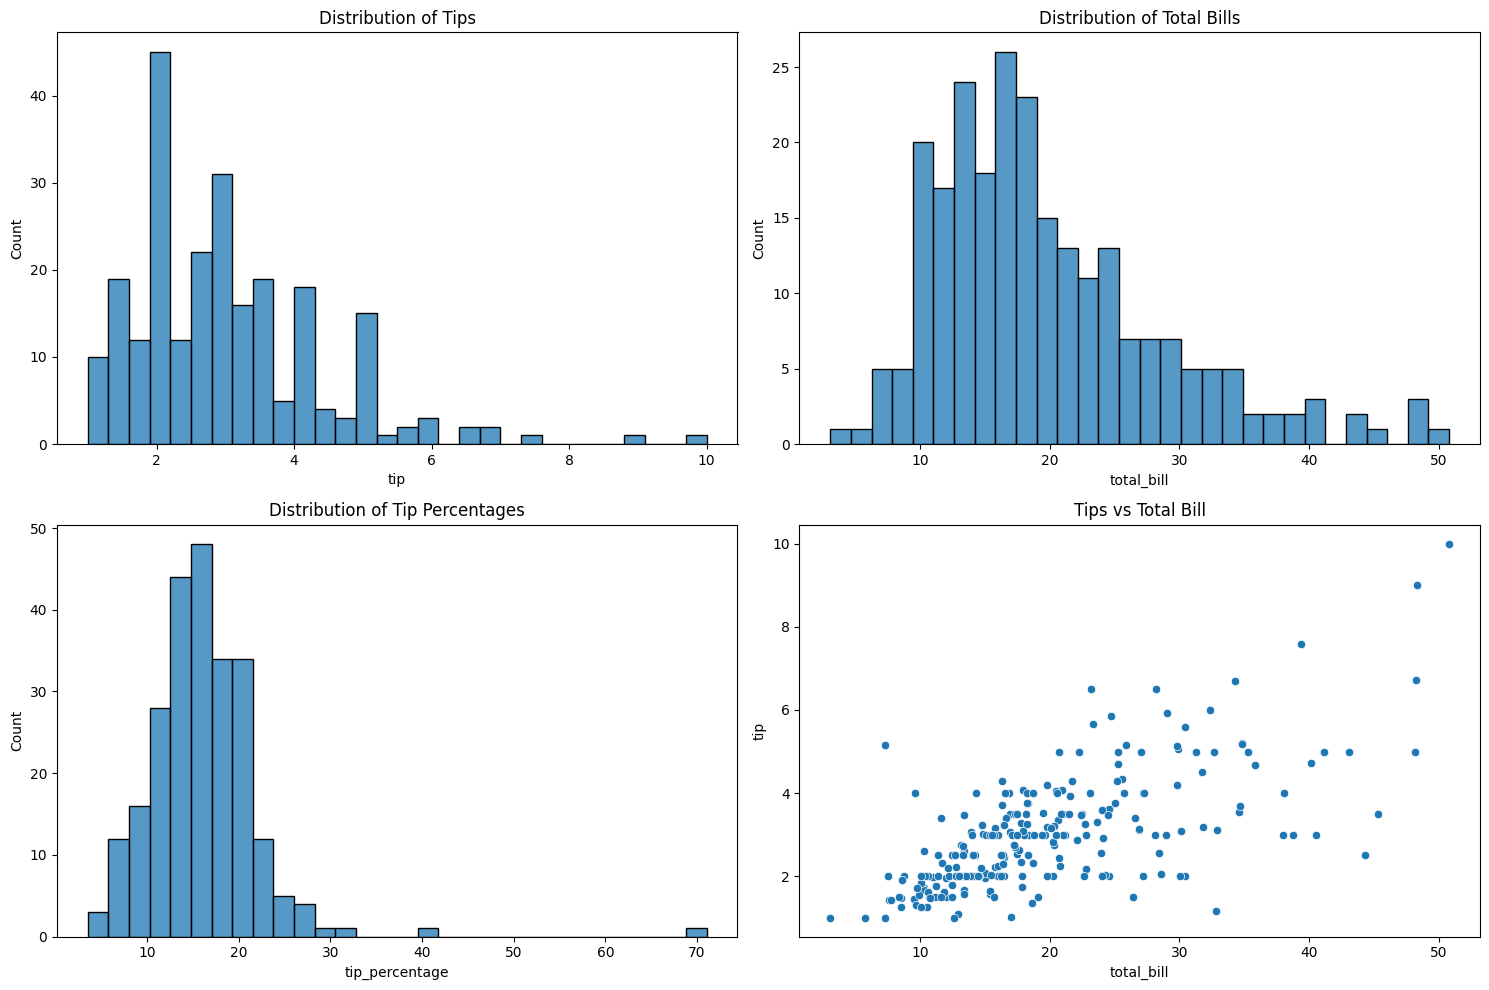

In [12]:
analyze_data_distribution(df)

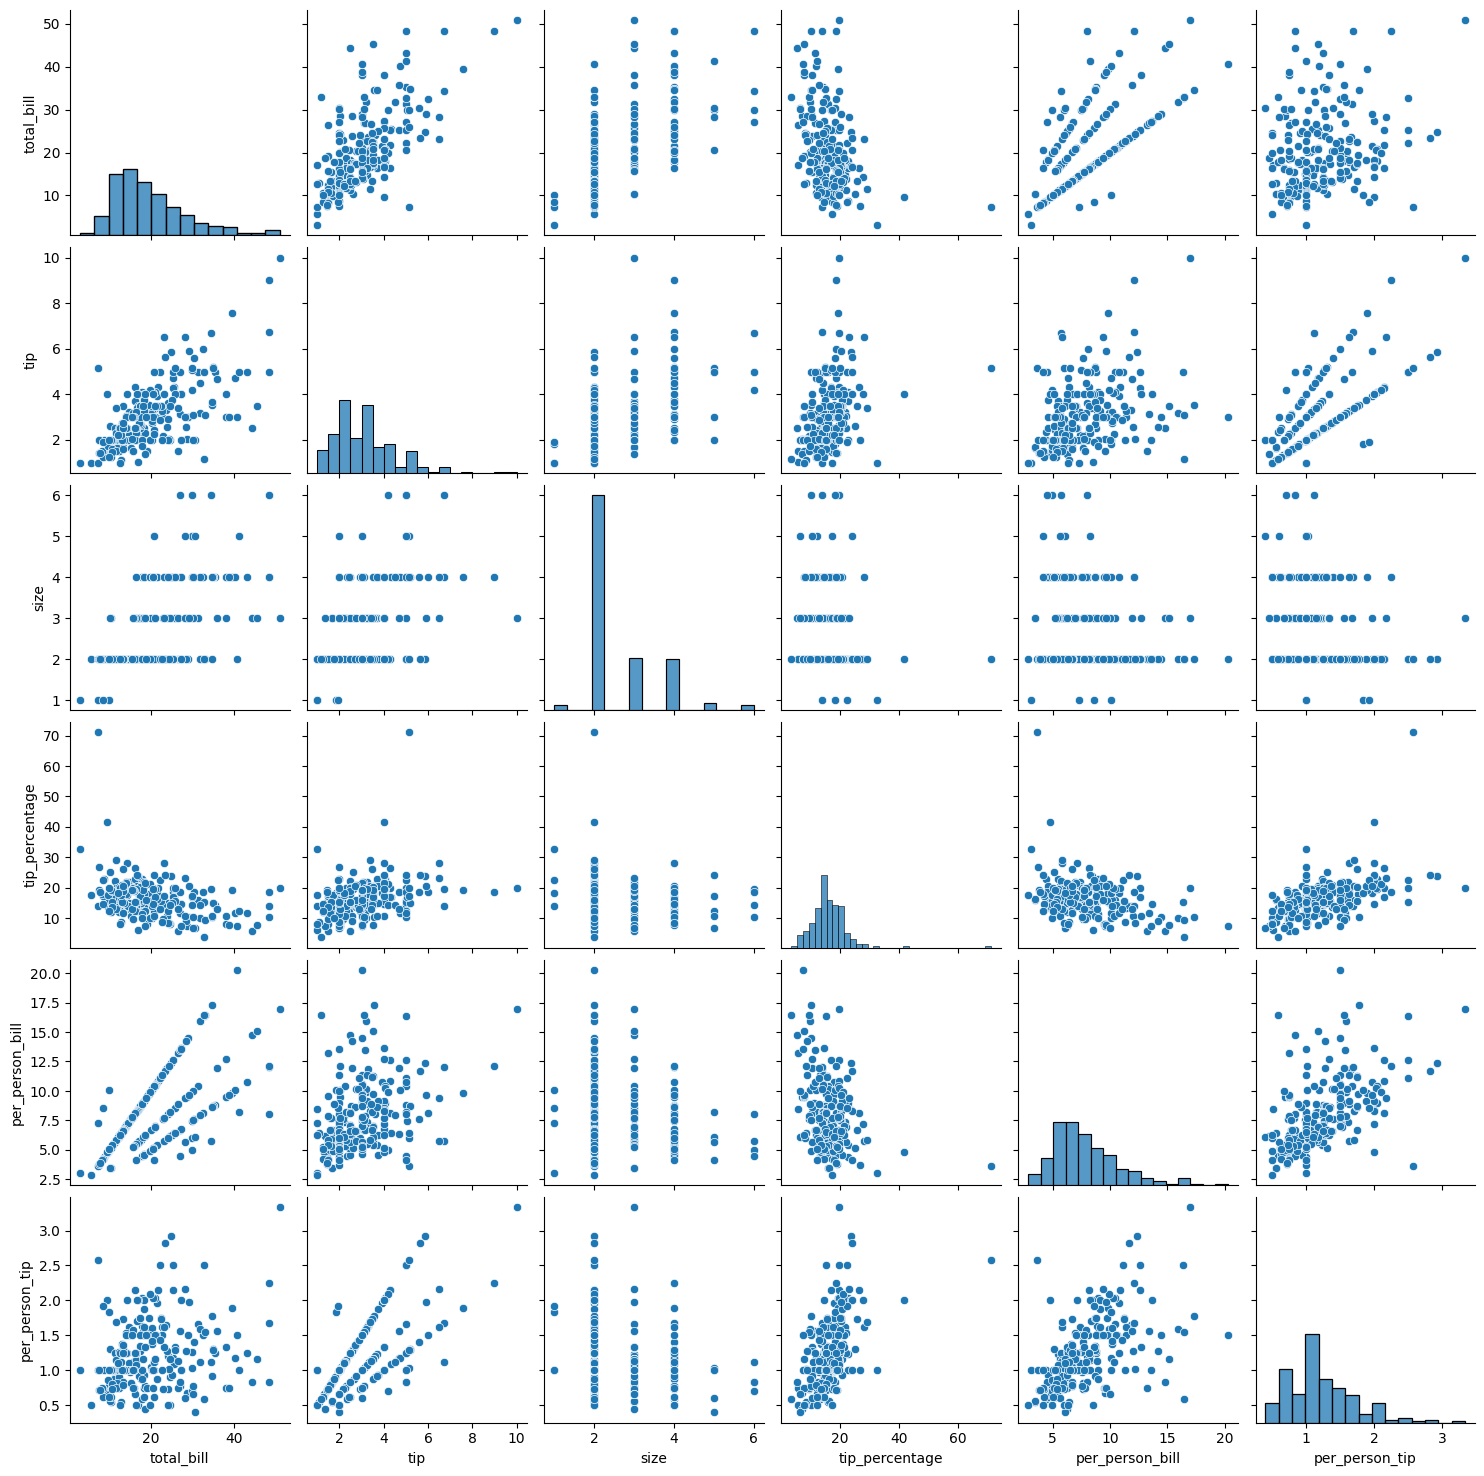

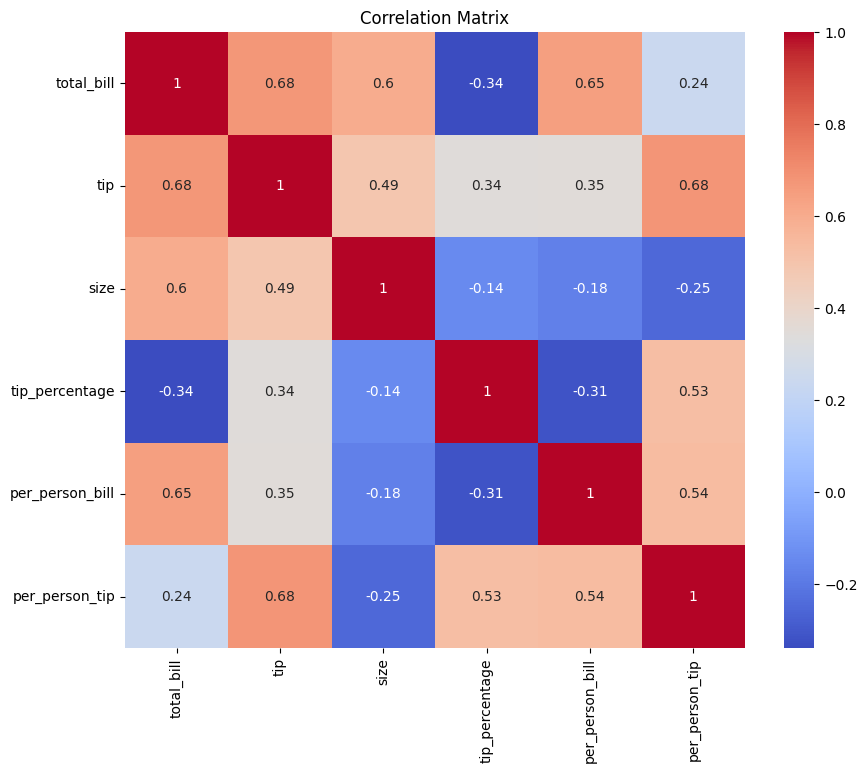


Rainbow Test Results:
Statistic: 1.1903
P-value: 0.1705


In [13]:
check_linearity(df)

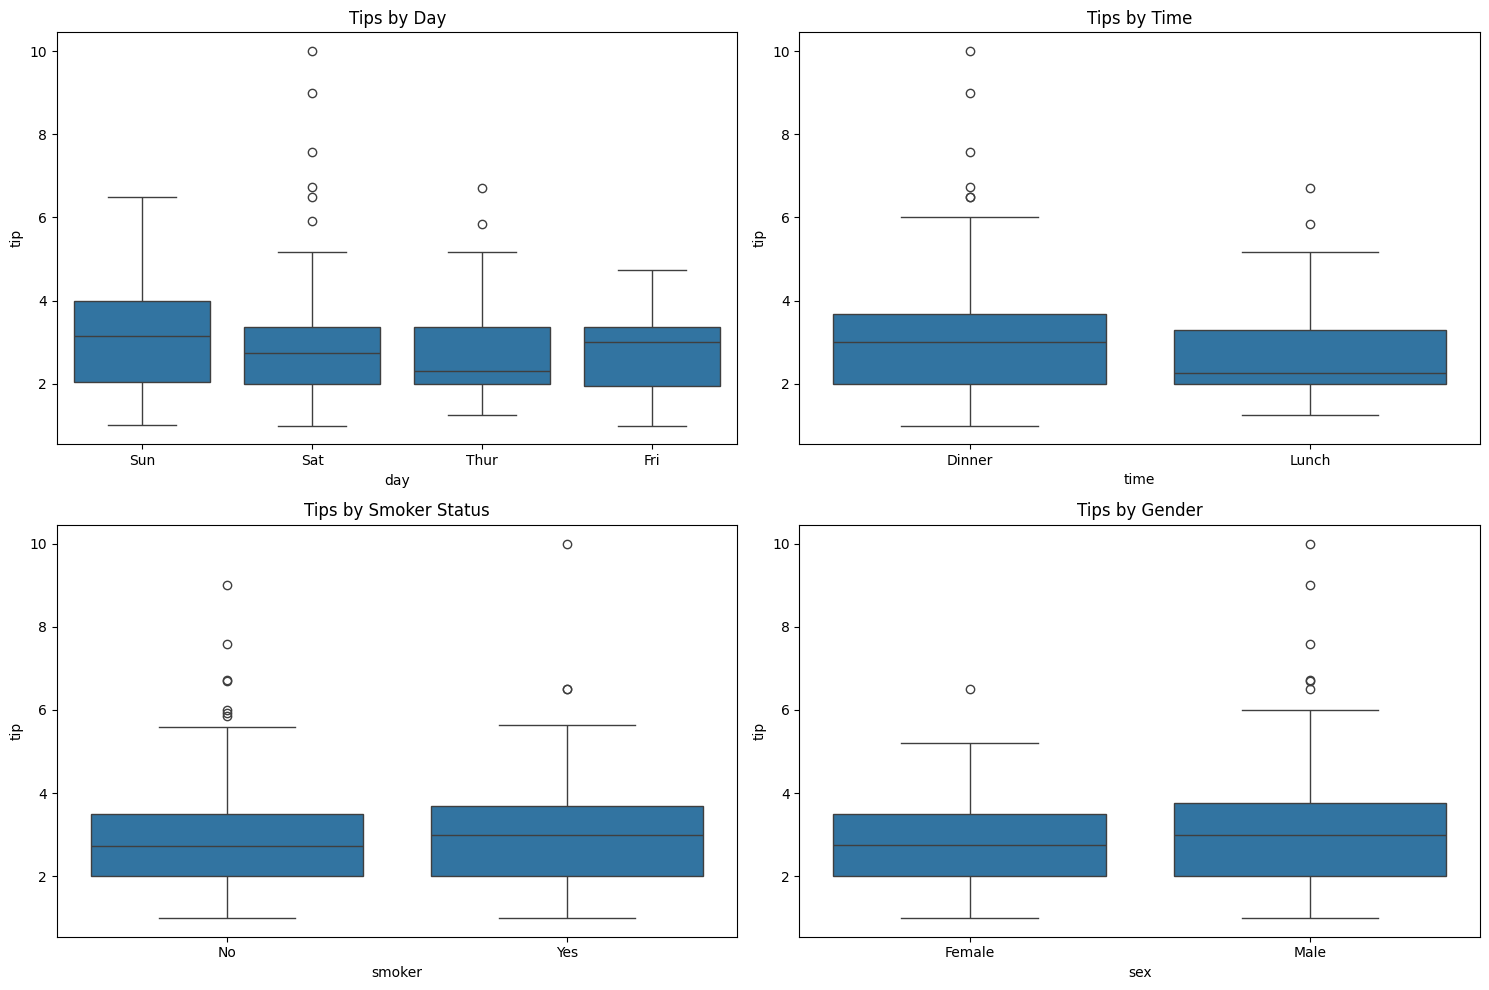

In [14]:
analyze_categorical_relationships(df)

In [28]:
X_train, X_test, y_train, y_test, feature_columns = prepare_modeling_data(df)


Linear Regression Results:
MSE: 0.0964
RMSE: 0.3104
MAE: 0.2694
R2 Score: 0.3649

Ridge Regression Results:
MSE: 0.0959
RMSE: 0.3098
MAE: 0.2674
R2 Score: 0.3677

Lasso Regression Results:
MSE: 0.0950
RMSE: 0.3082
MAE: 0.2647
R2 Score: 0.3739

Decision Tree Results:
MSE: 0.1531
RMSE: 0.3912
MAE: 0.3002
R2 Score: -0.0086

Random Forest Results:
MSE: 0.1072
RMSE: 0.3273
MAE: 0.2761
R2 Score: 0.2939

Feature Importance:
           feature  importance
0       total_bill    0.694975
6  per_person_bill    0.163812
1             size    0.044925
4      day_encoded    0.037464
3   smoker_encoded    0.035381
2      sex_encoded    0.013393
5     time_encoded    0.010050


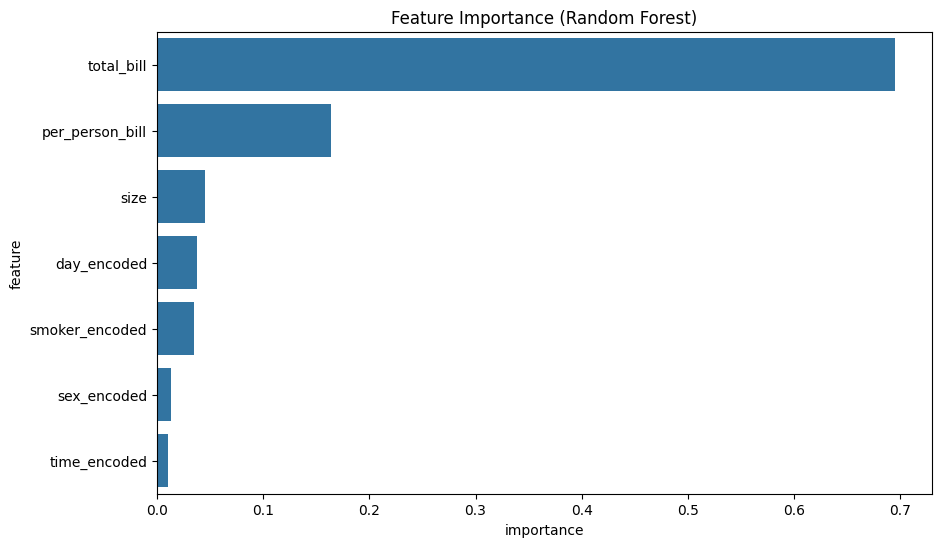


SVR Results:
MSE: 0.0953
RMSE: 0.3087
MAE: 0.2415
R2 Score: 0.3720

KNN Results:
MSE: 0.1350
RMSE: 0.3674
MAE: 0.3001
R2 Score: 0.1104


In [29]:
results = train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_columns)

In [30]:
print("\nKey Insights:")
print("1. Most significant factors affecting tip amounts:")
print("2. Best performing model:", max(results.items(), key=lambda x: x[1]['R2'])[0])
print("3. Average prediction error (MAE):", np.mean([model['MAE'] for model in results.values()]))



Key Insights:
1. Most significant factors affecting tip amounts:
2. Best performing model: Lasso Regression
3. Average prediction error (MAE): 0.2741910577700689
